In [1]:
from   matplotlib  import pyplot as plt

from   scipy.fft   import fft, ifft
from   model       import MultiVariateGaussian

import numpy  as np
import pandas as pd

import os

colors  = plt.rcParams['axes.prop_cycle'].by_key()['color']
width   = 0.35

In [2]:
# read in the raw data
data = {}

for file in os.listdir('data'):
    num = int(file[1:])
    data[num] = [pd.read_csv(f'data/{file}/{f}', header = None) for f in sorted(os.listdir(f'data/{file}'))]
    
# remove exception files
# 9  (2) has 10 rows
# 33 (2) has weird max value in column B
for exception in [9, 33]:
    del data[exception]
    
X1, X2, X0 = zip(*data.values())

# extract features from each corresponding x file
Z0, Z1, Z2 = [], [], []

for (X, Z) in zip([X0, X1, X2], [Z0, Z1, Z2]):
    
    for x in X:
        z = []
        x = np.array(x)[:,1:]                                                                # ignore time column

        # loop through the raw data and fft of data and obtain the features mean, min, max, and std
        for xf in [x, abs(fft(x))]:
            z.append(xf.mean(axis = 0))
            z.append(xf.min(axis = 0))
            z.append(xf.max(axis = 0))
            z.append(xf.std(axis = 0))

        # compute mean and std of the interval between the peaks
        f = pd.DataFrame(x).rolling(5, min_periods = 5, center = True).mean().values[2:-2,0] # smooth local simple average of breathe
        d = np.where((f[1:-1] > f[:-2]) & (f[1:-1] > f[2:]))[0]                              # local peak indices
        d = d[1:] - d[:-1]                                                                   # redefine to be interval between peaks

        z.append([d.mean()])
        z.append([d.std()])

        # flatten all features and append
        z = np.concatenate(z)
        Z.append(z)

Z0, Z1, Z2 = map(np.array, [Z0, Z1, Z2])

# define computed features (4 x 3 x 2 + 2)
features  = [f'{fun} {feat}' for fun in ['mean', 'min', 'max', 'std'] for feat in ['breathe', 'pressure', 'cycle']]
features += [f'fft {f}' for f in features]
features += ['mean interval', 'std interval']

features  = np.array(features)

# min and max cycle values always equal -1 and +1 so delete these non-informative features
mask      = (features != 'min cycle') & (features != 'max cycle')

Z0, Z1, Z2 = [Z[:,mask] for Z in [Z0, Z1, Z2]]
features   = features[mask]

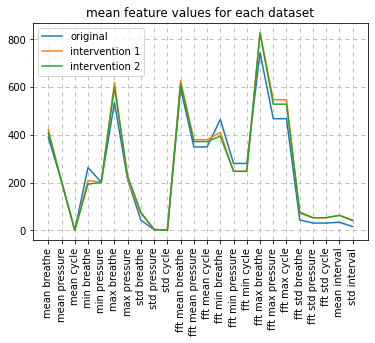

In [3]:
# visualise mean feature values across participants to see if there is a visual difference
labels = ['original', 'intervention 1', 'intervention 2']

for Z, label in zip([Z0, Z1, Z2], labels):
    plt.plot(Z.mean(axis = 0), label = label)

plt.xticks(range(len(features)), features, rotation = 90)

plt.legend()
plt.grid(ls = (0, (5, 5)))
plt.title('mean feature values for each dataset')
plt.show()

['mean breathe' 'mean pressure' 'mean cycle' 'min breathe' 'min pressure'
 'max breathe' 'max pressure' 'std breathe' 'std pressure' 'std cycle'
 'fft mean breathe' 'fft mean pressure' 'fft mean cycle' 'fft min breathe'
 'fft min pressure' 'fft min cycle' 'fft max breathe' 'fft max pressure'
 'fft max cycle' 'fft std breathe' 'fft std pressure' 'fft std cycle'
 'mean interval' 'std interval']


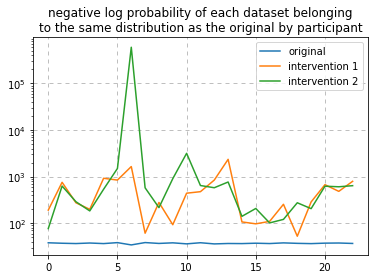

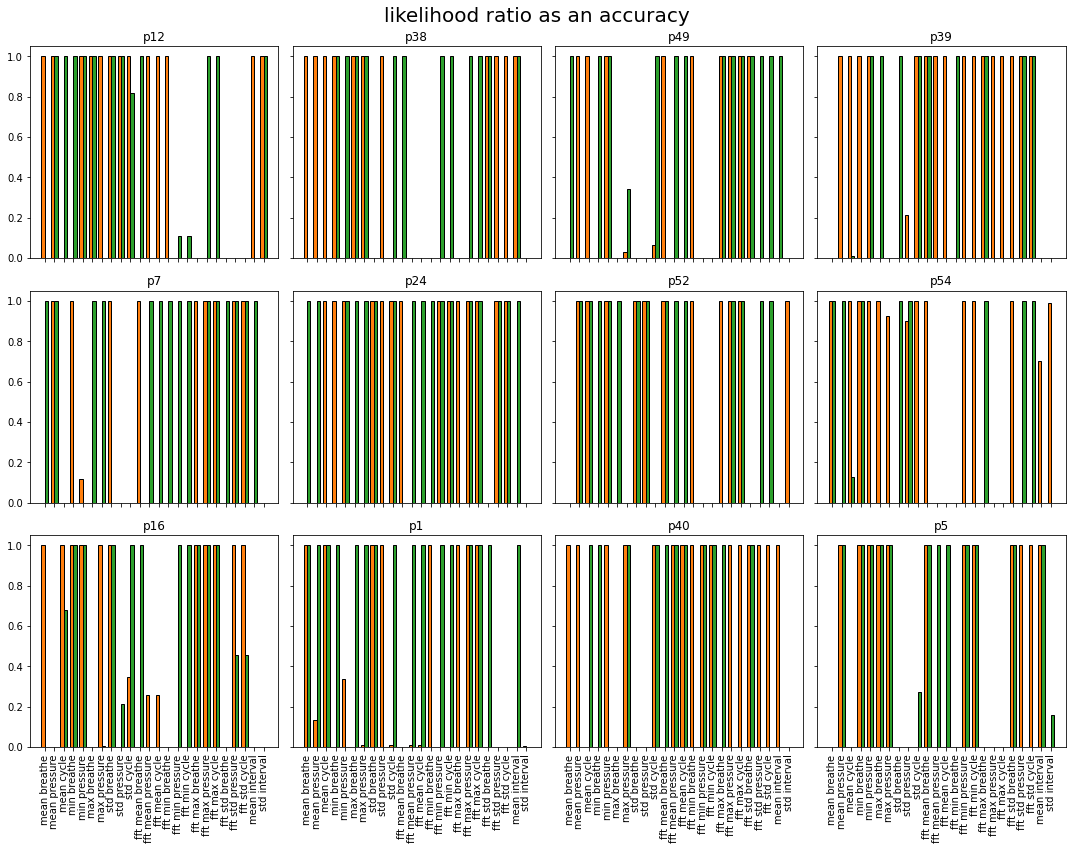

In [4]:
model = MultiVariateGaussian(features)

print(model.features)

model.fit(Z0)

for nll, label in zip(model.nll(Z0, Z1, Z2), labels):
    plt.semilogy(nll, label = label)

plt.legend()
plt.grid(ls = (0, (5, 5)))
plt.title('negative log probability of each dataset belonging\nto the same distribution as the original by participant')
plt.show()


R0, R1, R2 = model.l_ratio_by_feature(Z0, Z1, Z2)

x = np.arange(len(model.features))

# first 12 participants only
fig, ax = plt.subplots(3, 4, figsize = (15, 12), sharey = True, sharex = True)
ax      = ax.flatten()

for i in range(12):
    
    ax[i].bar(x - width / 2, R1[i], width, ec = 'k', fc = colors[1])
    ax[i].bar(x + width / 2, R2[i], width, ec = 'k', fc = colors[2])
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(model.features, rotation = 90)
    ax[i].set_title(f'p{list(data)[i]}')

fig.suptitle('likelihood ratio as an accuracy', size = 20)
plt.tight_layout()

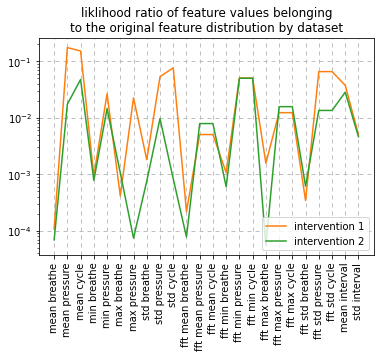

        intervention 1                   intervention 2

 1.     mean breathe       (1.1e-04)     fft max breathe    (5.5e-05)
 2.     fft mean breathe   (2.2e-04)     mean breathe       (6.9e-05)
 3.     fft std breathe    (3.5e-04)     max pressure       (7.4e-05)
 4.     max breathe        (4.1e-04)     fft mean breathe   (7.8e-05)
 5.     min breathe        (9.4e-04)     fft min breathe    (6.0e-04)
 6.     fft min breathe    (1.1e-03)     fft std breathe    (6.2e-04)
 7.     fft max breathe    (1.6e-03)     std breathe        (7.6e-04)
 8.     std breathe        (1.8e-03)     min breathe        (7.8e-04)
 9.     std interval       (5.0e-03)     std cycle          (8.3e-04)
10.     fft mean pressure  (5.1e-03)     max breathe        (1.1e-03)
11.     fft mean cycle     (5.1e-03)     std interval       (4.6e-03)
12.     fft max cycle      (1.2e-02)     fft mean pressure  (7.9e-03)
13.     fft max pressure   (1.2e-02)     fft mean cycle     (7.9e-03)
14.     max pressure       (2.3e-

In [5]:
L0, L1, L2 = model.ll_ratio_by_feature(Z0, Z1, Z2)
D1, D2     = np.maximum(L0 - L1, 0), np.maximum(L0 - L2, 0)

M1, M2     = 1 / D1.mean(axis = 0), 1 / D2.mean(axis = 0)
plt.semilogy(M1, c = colors[1], label = labels[1])
plt.semilogy(M2, c = colors[2], label = labels[2])

plt.xticks(range(len(model.features)), model.features, rotation = 90)
plt.grid(ls = (0, (5, 5)))
plt.legend()
plt.title('liklihood ratio of feature values belonging\nto the original feature distribution by dataset')
plt.show()

O1, O2 = M1.argsort(), M2.argsort()

print(f'        {"intervention 1":32s} intervention 2\n')
for i, (o1, o2) in enumerate(zip(O1, O2), 1):
    print(f'{i:2d}.     {model.features[o1]:18s} ({M1[o1]:.1e})     {model.features[o2]:18s} ({M2[o2]:.1e})')

['mean breathe' 'min breathe' 'max breathe' 'std breathe'
 'fft mean breathe' 'fft min breathe' 'fft max breathe' 'fft std breathe']


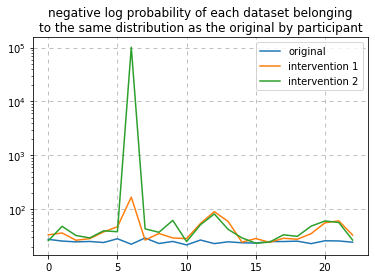

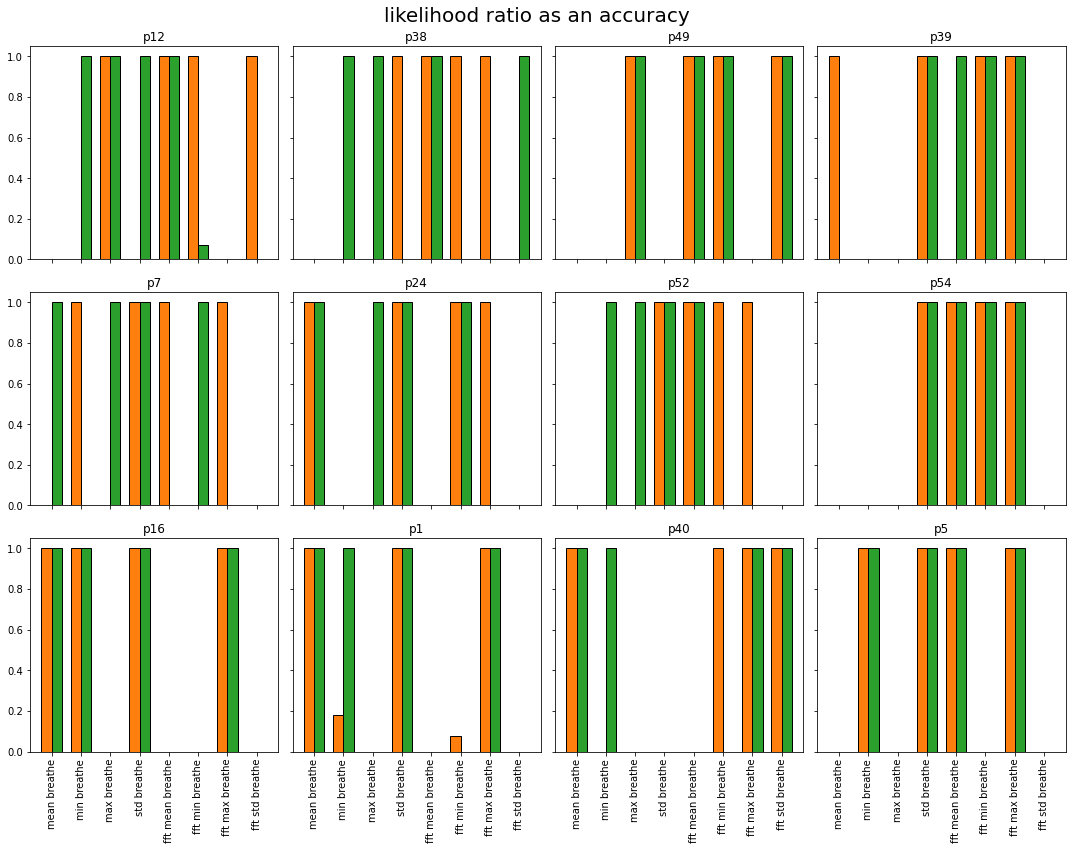

In [6]:
b_mask = ['breathe'  in f for f in features]

model.set_mask(b_mask)

print(model.features)

model.fit(Z0)

for nll, label in zip(model.nll(Z0, Z1, Z2), labels):
    plt.semilogy(nll, label = label)

plt.legend()
plt.grid(ls = (0, (5, 5)))
plt.title('negative log probability of each dataset belonging\nto the same distribution as the original by participant')
plt.show()


D0, D1, D2 = model.l_ratio_by_feature(Z0, Z1, Z2)

x = np.arange(len(model.features))

# first 12 participants only
fig, ax = plt.subplots(3, 4, figsize = (15, 12), sharey = True, sharex = True)
ax      = ax.flatten()

for i in range(12):
    
    ax[i].bar(x - width / 2, D1[i], width, ec = 'k', fc = colors[1])
    ax[i].bar(x + width / 2, D2[i], width, ec = 'k', fc = colors[2])
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(model.features, rotation = 90)
    ax[i].set_title(f'p{list(data)[i]}')

fig.suptitle('likelihood ratio as an accuracy', size = 20)
plt.tight_layout()

['mean pressure' 'min pressure' 'max pressure' 'std pressure'
 'fft mean pressure' 'fft min pressure' 'fft max pressure'
 'fft std pressure']


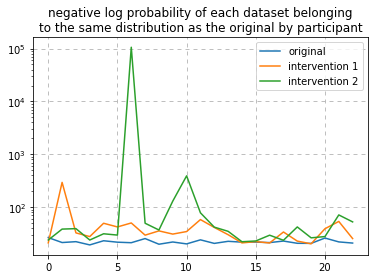

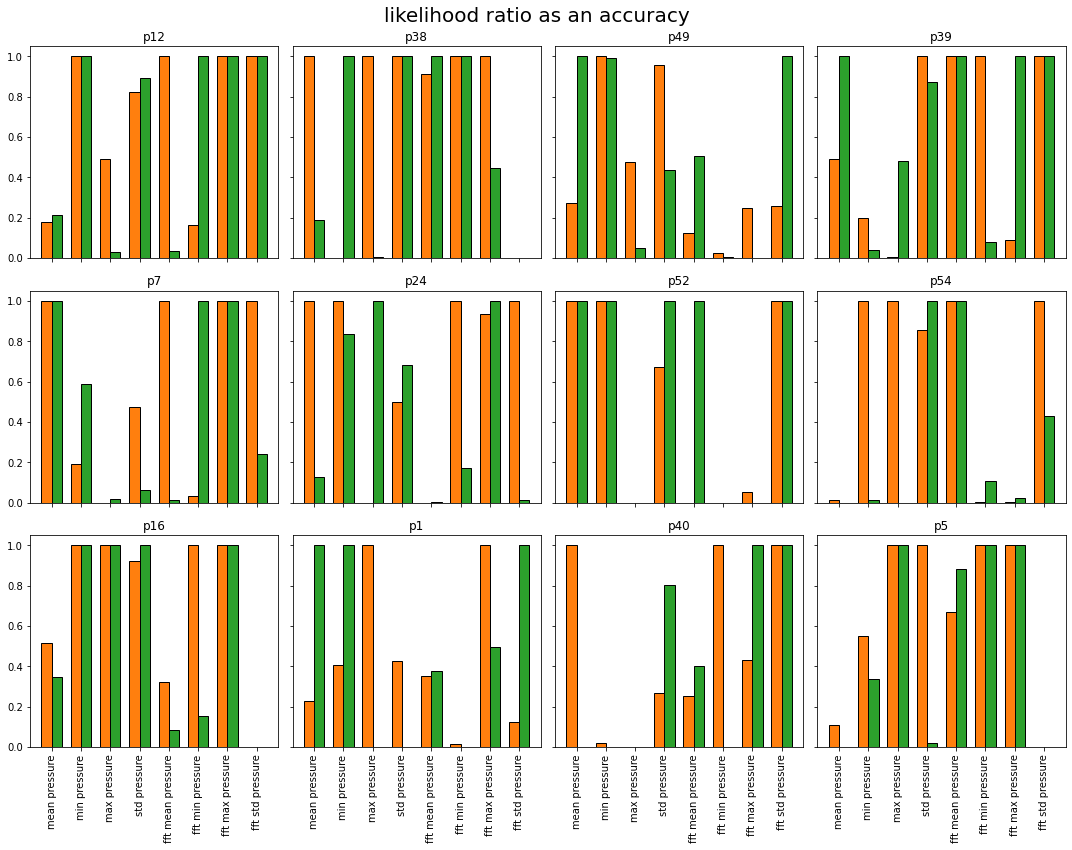

In [7]:
p_mask = ['pressure' in f for f in features]

model.set_mask(p_mask)

print(model.features)

model.fit(Z0)

for nll, label in zip(model.nll(Z0, Z1, Z2), labels):
    plt.semilogy(nll, label = label)

plt.legend()
plt.grid(ls = (0, (5, 5)))
plt.title('negative log probability of each dataset belonging\nto the same distribution as the original by participant')
plt.show()


D0, D1, D2 = model.l_ratio_by_feature(Z0, Z1, Z2)

x = np.arange(len(model.features))

# first 12 participants only
fig, ax = plt.subplots(3, 4, figsize = (15, 12), sharey = True, sharex = True)
ax      = ax.flatten()

for i in range(12):
    
    ax[i].bar(x - width / 2, D1[i], width, ec = 'k', fc = colors[1])
    ax[i].bar(x + width / 2, D2[i], width, ec = 'k', fc = colors[2])
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(model.features, rotation = 90)
    ax[i].set_title(f'p{list(data)[i]}')

fig.suptitle('likelihood ratio as an accuracy', size = 20)
plt.tight_layout()